[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
Original Model - FLOPs: 1276155904.0, Params: 86041346.0
Original Model - Average Inference Time: 0.031777913570404055
Quantized Model - Average Inference Time: 0.04790801763534546


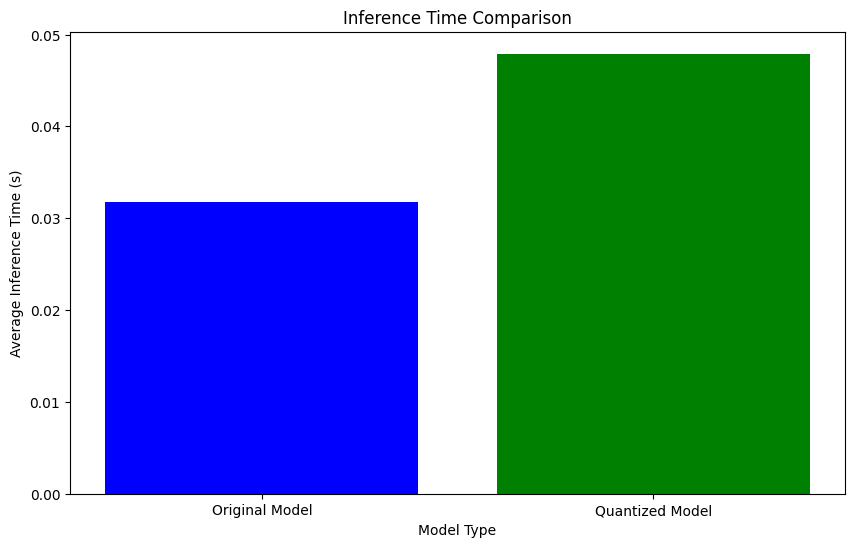

In [4]:
import os
import torch
from fakenews.config import BEST_MODEL, QUANTIZED_MODEL
from fakenews.model.model import BERTClass
from transformers import BertTokenizer
from thop import profile
import matplotlib.pyplot as plt
from fakenews.inference.quantitization import PlainBERTModel, measure_inference_time
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

# Ensure plots display in the notebook
%matplotlib inline

# Clear any existing Hydra instance
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

# Initialize Hydra and load the configuration
initialize(config_path="../config", version_base="1.2")
cfg = compose(config_name="config")

# Load the PyTorch Lightning model
model_checkpoint_path = os.path.join(BEST_MODEL, "model.ckpt")
pl_model = BERTClass.load_from_checkpoint(model_checkpoint_path, cfg=cfg)

# Create a plain PyTorch model
plain_model = PlainBERTModel(
    model_name=cfg.model.name,
    hidden_size=cfg.model.hidden_size,
    intermediate_size=cfg.model.intermediate_size,
    output_size=cfg.model.output_size,
    dropout_rate=cfg.model.dropout_rate,
)

# Load the state dict from the lightning model into the plain model
plain_model.load_state_dict(pl_model.state_dict())
plain_model.to("cpu")
device = torch.device("cpu")

# Calculate FLOPs for the original model
tokenizer = BertTokenizer.from_pretrained(cfg.model.name)
dummy_input = tokenizer(
    "This is a dummy input", return_tensors="pt", max_length=15, padding="max_length", truncation=True
)
input_ids = dummy_input["input_ids"].to(device)
attention_mask = dummy_input["attention_mask"].to(device)

flops, params = profile(plain_model, inputs=(input_ids, attention_mask))
print(f"Original Model - FLOPs: {flops}, Params: {params}")

# Measure inference time for the original model
original_inference_time = measure_inference_time(plain_model, input_ids, attention_mask, device)
print(f"Original Model - Average Inference Time: {original_inference_time}")

# Quantization
torch.backends.quantized.engine = "qnnpack"
quantized_model = torch.quantization.quantize_dynamic(plain_model, {torch.nn.Linear}, dtype=torch.qint8)

quantized_model_path = os.path.join(QUANTIZED_MODEL, "quantized_model.pth")
torch.save(quantized_model.state_dict(), quantized_model_path)

# Load the quantized model
state_dict = torch.load(quantized_model_path)
quantized_model.load_state_dict(state_dict)

# Measure inference time for the quantized model
quantized_inference_time = measure_inference_time(quantized_model, input_ids, attention_mask, device)
print(f"Quantized Model - Average Inference Time: {quantized_inference_time}")

# Plot the inference times
labels = ["Original Model", "Quantized Model"]
times = [original_inference_time, quantized_inference_time]

plt.figure(figsize=(10, 6))
plt.bar(labels, times, color=["blue", "green"])
plt.xlabel("Model Type")
plt.ylabel("Average Inference Time (s)")
plt.title("Inference Time Comparison")
plt.show()